# Проект e-commerce: вариант 1 
Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на несколько вопросов.

Для начала загрузим и проанализируем данные:

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

from urllib.parse import urlencode
import requests

In [15]:

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = ['https://disk.yandex.ru/d/QXrVDUoQvFhIcg',
              'https://disk.yandex.ru/d/0zWmh1bYP6REbw',
              'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg']
url =[]

# Получаем загрузочную ссылку
for key in public_key:
    final_url = base_url + urlencode(dict(public_key=key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    url.append(download_url)

In [21]:
customers = pd.read_csv(url[0])
orders = pd.read_csv(url[1], 
                     parse_dates = ['order_purchase_timestamp', 
                                    'order_approved_at',
                                    'order_delivered_carrier_date',
                                    'order_delivered_customer_date',
                                    'order_estimated_delivery_date'])
order_items = pd.read_csv(url[2])


посмотрим размер таблиц

In [23]:
print(customers.shape,orders.shape, order_items.shape)

(99441, 5) (99441, 8) (112650, 7)


Уникальные статусы заказов в таблице orders:

created —  создан

approved —  подтверждён

invoiced —  выставлен счёт

processing —  в процессе сборки заказа

shipped —  отгружен со склада

delivered —  доставлен пользователю

unavailable —  недоступен

canceled —  отменён

Для того, чтобы заказ считался покупкой, он должен быть оплачен, и доставлен клиенту, статус 'delivered'.
Cоздадим таблицу purchases, в котором оставим только строки с покупками


In [24]:
purchases = orders.loc[orders.order_status == 'delivered']

In [25]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96478 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96478 non-null  object        
 1   customer_id                    96478 non-null  object        
 2   order_status                   96478 non-null  object        
 3   order_purchase_timestamp       96478 non-null  datetime64[ns]
 4   order_approved_at              96464 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96476 non-null  datetime64[ns]
 6   order_delivered_customer_date  96470 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96478 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


При анализе видно, что среди покупок, которые имеют статус "delivered" есть строки с отсутствующими значениями в колонке
order_approved_at  - то есть заказ доставлен, но не имеет подтверждения оплаты. Такой заказ не может считаться покупкой. Вероятно, это сбой в системе оплаты, либо не заполнено вручную. Уберем эти строки.

In [26]:
purchases = purchases.loc[~purchases.order_approved_at.isna()].loc[~purchases.order_delivered_customer_date.isna()].loc[~purchases.order_delivered_carrier_date.isna()]


In [27]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96455 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       96455 non-null  object        
 1   customer_id                    96455 non-null  object        
 2   order_status                   96455 non-null  object        
 3   order_purchase_timestamp       96455 non-null  datetime64[ns]
 4   order_approved_at              96455 non-null  datetime64[ns]
 5   order_delivered_carrier_date   96455 non-null  datetime64[ns]
 6   order_delivered_customer_date  96455 non-null  datetime64[ns]
 7   order_estimated_delivery_date  96455 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.6+ MB


Теперь в таблице нет отсутствующих значений. 

# Вопрос 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Для ответа на это вопрос соединим таблицы purchases и customers.
Сгруппируем по customer_unique_id и посчитаем количество заказов по пользователям.
Отфильтруем только тех клиентов, у которых число заказов равно 1

In [28]:
task_1 = purchases.merge(customers, on = 'customer_id', how = 'inner')\
    .groupby('customer_unique_id', as_index = False)\
    .agg({'order_id':'count'})\
    .rename(columns = {'order_id' : 'purchases'})\
    .query('purchases == 1')
customer_num = task_1.shape[0]
print(f'Ответ: {customer_num} пользователей совершили одну покупку')

Ответ: 90536 пользователей совершили одну покупку


# Вопрос 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?
Определим заказ как факт присвоения ему номера order_id.

Выберем недоставленные заказы и рассмотрим причины недоставления.

In [29]:
not_delivered = orders.loc[orders.order_delivered_customer_date.isna()]
not_delivered.order_status.unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'delivered', 'created', 'approved'], dtype=object)

### <p style="text-align: center;"> ДЕТАЛИЗАЦИЯ ПРИЧИН</p>
 
    Ряд заказов имеют статусы: 'created', 'invoiced', 'processing',не предполагающие передачу их в службу логистики на данном этапе.
    
    Заказы со статусом  'unavailable'   недоступны по неизвестной причине. Возможно отсутствовали на складе к моменту передачи курьеру.
    
    Заказы со статусами: 'approved', 'shipped'  находятся в процессе передачи в службу логистики и доставки клиенту соответственно.
    
    Недоставленные заказы со статусом  'canceled'  были отменены до того как попали к клиенту.
    
    Среди заказов со статусом  'delivered'  есть заказы в которых не указана дата доставки клиенту.

   
   
Приведем колонку с датой покупки *order_purchase_timestamp* к виду год-месяц

______________________________________________________________________________________________

In [30]:
not_delivered['order_purchase_timestamp'] =not_delivered.order_purchase_timestamp.dt.to_period("M")



/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Сгруппируем таблицу по месяцу оплаты и статусу заказа и найдем среднее значение для каждого статуса


In [31]:
task_2 = not_delivered.groupby(['order_purchase_timestamp', 'order_status'], as_index = False) \
        .agg({'order_id': 'count'}) \
        .groupby('order_status', as_index = False) \
        .agg({'order_id': 'mean'}) \
        .rename(columns = {'order_id': 'avg_orders'}) \
        .sort_values('avg_orders', ascending = False)
task_2

,order_status,avg_orders
6,shipped,48.130435
7,unavailable,29.000000
1,canceled,25.791667
5,processing,15.842105
4,invoiced,14.952381
3,delivered,2.000000
2,created,1.666667
0,approved,1.000000


визуализируем данные

Text(0.5, 0, 'Среднее количество недоставленных заказов')

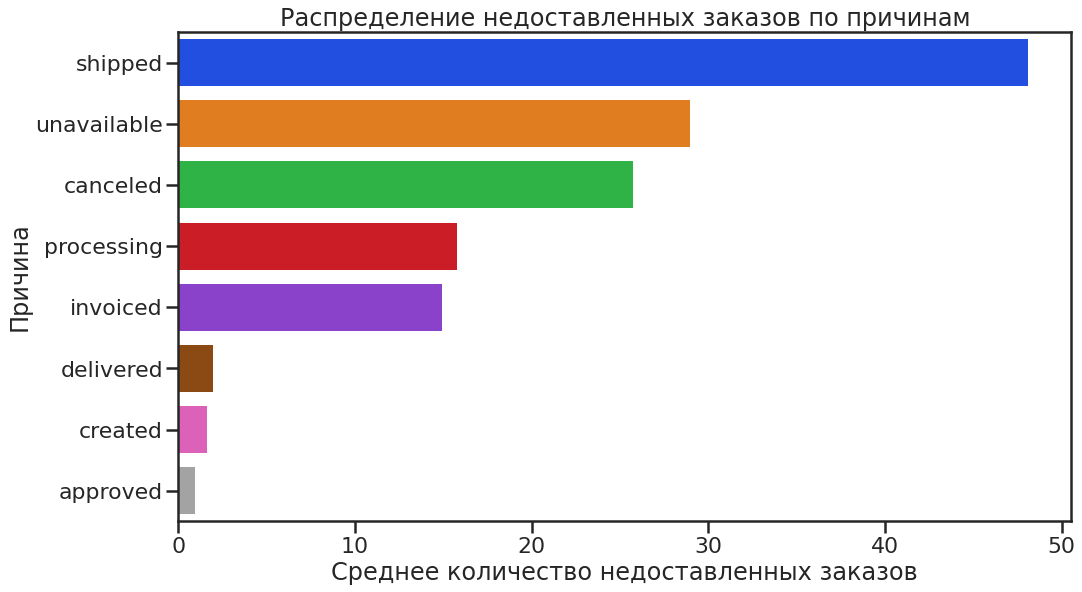

In [32]:
plt.figure(figsize = (16,9))

sns.set(context= 'poster',style='ticks', palette='bright', font_scale=1)
sns.barplot(data = task_2, x = 'avg_orders', y = 'order_status')
plt.title('Распределение недоставленных заказов по причинам')
plt.ylabel('Причина')
plt.xlabel('Среднее количество недоставленных заказов')

Вывод:

В среднем, наибольшее количество заказов не доставляется по причине задержки в службах логистики.
    
Вторая причина - статус 'unavailable'. Я расценил ее как отсутствие на складе в момент передачи курьеру.

И третья причина - отмена заказа клиентом

# Вопрос 3. По каждому товару определить, в какой день недели товар чаще всего покупается.
Временные метки лежат в таблице orders, а сведения о товарах в заказе  - в order_items. Объединим таблицы и переведем колонку order_purchase_timestamp в дни недели

In [33]:
sales_per_dow = orders.merge(order_items, how = 'inner', on = 'order_id')
sales_per_dow['day_of_week'] = sales_per_dow['order_purchase_timestamp'].dt.dayofweek
sales_per_dow.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,1
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,2
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,5
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,1


Далее сгруппируем по товарам и дням недели и посчитаем количество продаж

In [34]:
sales_per_dow = sales_per_dow.groupby(['product_id','day_of_week'], as_index = False) \
    .agg({'order_id': 'count'}) \
    .rename(columns = {'order_id':'sales'})
sales_per_dow.head()

,product_id,day_of_week,sales
0,00066f42aeeb9f3007548bb9d3f33c38,6,1
1,00088930e925c41fd95ebfe695fd2655,1,1
2,0009406fd7479715e4bef61dd91f2462,3,1
3,000b8f95fcb9e0096488278317764d19,2,1
4,000b8f95fcb9e0096488278317764d19,4,1


Переведем таблицу в вид, где столбцами являются дни недели, а строками - товары и выберем максимальное значение.
Переведем Series обратно в датафрейм

In [35]:
sales_per_dow = sales_per_dow.pivot(index = 'product_id', columns = 'day_of_week', values = 'sales' )\
    .idxmax(axis =1) \
    .reset_index() \
    .rename(columns = {0:'day_of_week'})
sales_per_dow.head()

,product_id,day_of_week
0,00066f42aeeb9f3007548bb9d3f33c38,6
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,3
3,000b8f95fcb9e0096488278317764d19,2
4,000d9be29b5207b54e86aa1b1ac54872,1


In [36]:
sales_per_dow.head()

,product_id,day_of_week
0,00066f42aeeb9f3007548bb9d3f33c38,6
1,00088930e925c41fd95ebfe695fd2655,1
2,0009406fd7479715e4bef61dd91f2462,3
3,000b8f95fcb9e0096488278317764d19,2
4,000d9be29b5207b54e86aa1b1ac54872,1


In [37]:
sales_per_dow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   product_id   32951 non-null  object
 1   day_of_week  32951 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 515.0+ KB


In [38]:
order_items.product_id.nunique()

32951

Поскольку в изначальной таблице была 32951 уникальная позиция товара, то таблица sales_per_dow является ответом на вопрос. Но для наглядности визуализируем распределение продаж продуктов по дням недели

In [39]:
indexes = {0:'monday',1: 'tuesday',2: 'wednesday',3: 'thursday',4: 'friday',5: 'saturday',6: 'sunday'}
for_visual = sales_per_dow.groupby('day_of_week')\
    .product_id.count().reset_index()\
    .rename(columns = {'product_id': 'amount'}, index = indexes )

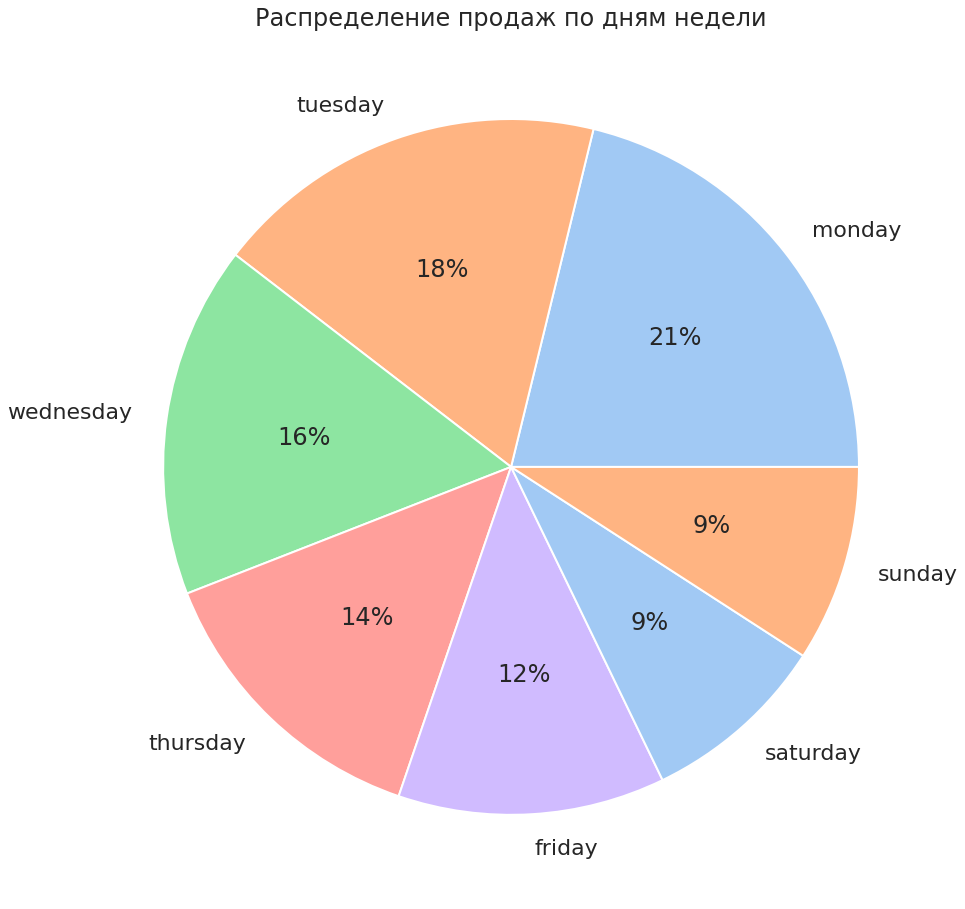

In [40]:
plt.figure(figsize = (16,16))
colors = sns.color_palette('pastel')[0:5]
plt.pie(for_visual.amount, labels = for_visual.index,  colors = colors, autopct='%.0f%%')
plt.title('Распределение продаж по дням недели')

plt.show()

# Вопрос 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.
Ранее мы определили, что покупкой является заказ, который оплачен, и доставлен клиенту, статус 'delivered' (таблица purchases).
Соединим датафреймы *customers* и *purchases* по *customer_id* и оставим нужные колонки

In [41]:
customers_purchases = customers.merge(purchases, how = 'inner', on ='customer_id')
customers_purchases = customers_purchases[['customer_unique_id','order_id', 'order_purchase_timestamp']]

Определим количество недель в месяце для каждого заказа. Добавим колонку с месяцем и годом покупки, колонку с количеством дней в этом месяце и поделим на количество дней в неделе

In [42]:
customers_purchases['purch_month'] = customers_purchases.order_purchase_timestamp.dt.strftime('%Y-%m')

In [43]:
customers_purchases['weeks'] = pd.to_datetime(customers_purchases.purch_month).dt.daysinmonth / 7

Сгруппируем по клиентам и месяцам,посчитаем количество заказов, разделим его на количество недель.
Это и будет среднее количество покупок в неделю для каждого пользователя

In [44]:
task_4 = customers_purchases.groupby(['customer_unique_id','purch_month'], as_index = False)\
    .agg({'weeks': 'mean', 'order_id':'count'})\
    .sort_values('order_id', ascending = False)
    
task_4['week_avg_purch'] = task_4.order_id / task_4.weeks



In [45]:
task_4.head()

,customer_unique_id,purch_month,weeks,order_id,week_avg_purch
7099,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.428571,6,1.354839
74543,c8460e4251689ba205045f3ea17884a1,2018-08,4.428571,4,0.903226
23216,3e43e6105506432c953e165fb2acf44c,2018-02,4.000000,4,1.000000
65757,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4.285714,4,0.933333
14054,25a560b9a6006157838aab1bdbd68624,2017-04,4.285714,4,0.933333


# Вопрос 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. 
Воспользуемся таблицей *purchases* которую получили в начале проекта. добавим к ней таблицу *customers* и уберем лишние колонки

In [46]:
cust_and_purch = customers.merge(purchases, how = 'inner', on ='customer_id')\
    .drop(columns = ['order_status', 'order_approved_at',
                     'order_delivered_carrier_date',
                     'order_delivered_customer_date',
                     'order_estimated_delivery_date',
                     'customer_zip_code_prefix',
                     'customer_city',
                     'customer_state'])

Нас интересует период в один год с 01.01.2017 по 31.12.2017. Отфильтруемся по дате и отобразим колонку *order_purchase_timestamp* в виде номера месяца

In [47]:
cust_and_purch=cust_and_purch.query("'2017-01-01 00:00:00'<=order_purchase_timestamp<='2017-12-01 23:59:59'")

cust_and_purch['order_purchase_timestamp']=cust_and_purch['order_purchase_timestamp'].dt.month

In [48]:
cust_and_purch.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,5
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,9
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,11
10,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,11
12,b2d1536598b73a9abd18e0d75d92f0a3,918dc87cd72cd9f6ed4bd442ed785235,83d8f70418eefd96f37b483dff430305,9


Определим месяц первой покупки для каждого пользователя и добавим эту колонку в рабочую таблицу

In [49]:

first_purchase=cust_and_purch.groupby('customer_unique_id') \
    .order_purchase_timestamp.min() \
    .reset_index()\
    .rename(columns={'order_purchase_timestamp' : 'first_purchase_month'})\
   
cust_and_purch = cust_and_purch.merge(first_purchase, how = 'inner', on = 'customer_unique_id')
cust_and_purch.head()   

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,first_purchase_month
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,5,5
1,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,9,9
2,802bb9a59876a712f8380da8f297057c,4c93744516667ad3b8f1fb645a3116a4,98b737f8bd00d73d9f61f7344aadf717,10,9
3,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,11,11
4,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,11,11


Рассчитаем разницу во времени между первой и последующими покупками

In [50]:
cust_and_purch['time_diff'] = cust_and_purch.order_purchase_timestamp - cust_and_purch.first_purchase_month
cust_and_purch.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,first_purchase_month,time_diff
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,5,5,0
1,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,5741ea1f91b5fbab2bd2dc653a5b5099,9,9,0
2,802bb9a59876a712f8380da8f297057c,4c93744516667ad3b8f1fb645a3116a4,98b737f8bd00d73d9f61f7344aadf717,10,9,1
3,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,1093c8304c7a003280dd34598194913d,11,11,0
4,9fb35e4ed6f0a14a4977cd9aea4042bb,2a7745e1ed516b289ed9b29c7d0539a5,8428e578bb1cf839ae26a6b7615502b9,11,11,0


Объединим покупателей в когорты по дате первой покупки и разнице между первой и второй покупкой,и посчитаем количество покупателей.

In [51]:
cohort=cust_and_purch.groupby(['first_purchase_month','time_diff'],as_index=False).agg({'customer_unique_id':'nunique'})
cohort.head(12)


,first_purchase_month,time_diff,customer_unique_id
0,1,0,716
1,1,1,2
2,1,2,2
3,1,3,1
4,1,4,3
5,1,5,1
6,1,6,3
7,1,7,1
8,1,8,1
9,1,10,3


Приведем датафрейм к следующему виду: в индексах строк будут стоять номера когорт, в колонках - месяцы повторных покупок, в ячейках датафрейма - количество повторных покупок

In [52]:

cohort=cohort.pivot(index='first_purchase_month', columns = 'time_diff', values = 'customer_unique_id')
cohort

time_diff,0,1,2,3,4,5,6,7,8,9,10
first_purchase_month,,,,,,,,,,,
1,716.0,2.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,3.0
2,1616.0,3.0,5.0,2.0,7.0,2.0,4.0,3.0,1.0,3.0,NaN
3,2503.0,11.0,9.0,10.0,9.0,4.0,4.0,8.0,8.0,NaN,NaN
4,2257.0,14.0,5.0,4.0,6.0,6.0,8.0,7.0,1.0,NaN,NaN
5,3450.0,16.0,16.0,10.0,10.0,11.0,14.0,NaN,NaN,NaN,NaN
6,3037.0,15.0,12.0,13.0,9.0,12.0,NaN,NaN,NaN,NaN,NaN
7,3753.0,20.0,13.0,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN
8,4057.0,28.0,14.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4004.0,28.0,22.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Для определения *retention rate*, возьмем количество покупателей в когорте и разделим на нее нашу таблицу

In [53]:
cohort_first = cohort[0]

In [54]:
cohort = (cohort / cohort_first).round(4)

In [55]:
cohort

,0,1,2,3,4,5,6,7,8,9,10,11,12
first_purchase_month,,,,,,,,,,,,,
1,NaN,0.0028,0.0012,0.0004,0.0013,0.0003,0.0010,0.0003,0.0002,NaN,0.0007,NaN,NaN
2,NaN,0.0042,0.0031,0.0008,0.0031,0.0006,0.0013,0.0008,0.0002,0.0007,NaN,NaN,NaN
3,NaN,0.0154,0.0056,0.0040,0.0040,0.0012,0.0013,0.0021,0.0020,NaN,NaN,NaN,NaN
4,NaN,0.0196,0.0031,0.0016,0.0027,0.0017,0.0026,0.0019,0.0002,NaN,NaN,NaN,NaN
5,NaN,0.0223,0.0099,0.0040,0.0044,0.0032,0.0046,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,0.0209,0.0074,0.0052,0.0040,0.0035,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,0.0279,0.0080,0.0036,0.0049,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,0.0391,0.0087,0.0044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,0.0391,0.0136,0.0004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
max_retention = cohort[3].idxmax()
print(f'Когорта с самым высоким retention на 3й месяц под номером {max_retention}')

Когорта с самым высоким retention на 3й месяц под номером 6


# Вопрос 6.Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

Соединим таблицы *order_items*, в которой находятся данные о ценах,  *purchases*, в которой находятся данные о покупках  и *customers*, в которой находятся данные о клиентах. выберем нужные нам колонки. Анализ проведем для времени отметки о покупке

In [57]:
sales = purchases.merge(order_items, how = 'left', on ='order_id'). merge(customers, on ='customer_id')
sales = sales[['order_id','customer_unique_id','order_purchase_timestamp', 'price']]

Определим период, за который присутствуют данные

In [58]:
print('Orders from {} to {}'.format(sales['order_purchase_timestamp'].min(),
                                    sales['order_purchase_timestamp'].max()))


Orders from 2016-09-15 12:16:38 to 2018-08-29 15:00:37


У нас есть данные о продажах почти за два года (с сентября 2016 по август 2018). Для анализа возьмем этот период.
Проверим, сколько строк приходится на каждый *order_id*

In [59]:
sales['order_id'].value_counts().head()

8272b63d03f5f79c56e9e4120aec44ef    21
ab14fdcfbe524636d65ee38360e22ce8    20
1b15974a0141d54e36626dca3fdc731a    20
428a2f660dc84138d969ccd69a0ab6d5    15
9ef13efd6949e4573a18964dd1bbe7f5    15
Name: order_id, dtype: int64

Получили, что на каждый order_id имеется несколько строк(каждая строка - один товар). Создадим таблицу *by_orders*, в котором просуммируем товары, чтобы получить: один заказ - одна цена

In [60]:
by_orders = sales.groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id']).agg({'price': lambda x: x.sum()}).reset_index()
by_orders.head()

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90


Смоделируем ситуацию, как будто анализ ведется через один день после последней покупки нашего периода

In [61]:
NOW = sales['order_purchase_timestamp'].max() + timedelta(days=1)
NOW


Timestamp('2018-08-30 15:00:37')

Добавим колонку *DaysSinceOrder* в которую запишем сколько дней прошло с даты последней покупки. Чтобы найти *recency* надо найти минимальное значение в этой колонке.
Оставим только строки, относящиеся по дате для нашего периода (в дальнейшем это поможет определить частоту)

In [62]:
by_orders['DaysSinceOrder'] = by_orders['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)
by_orders = by_orders.loc[by_orders.DaysSinceOrder >=0]
by_orders.head()

,order_id,order_purchase_timestamp,customer_unique_id,price,DaysSinceOrder
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,58.90,351
1,00018f77f2f0320c557190d7a144bdd3,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,239.90,491
2,000229ec398224ef6ca0657da4fc703e,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,199.00,228
3,00024acbcdf0a6daa1e931b038114c75,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12.99,22
4,00042b26cf59d7ce69dfabb4e55b4fd9,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,199.90,572


 Нам нужен датафрейм с одной строкой для одного клиента. Сгруппируем по *customer_unique_id*.
При этом агрегируем *recency* как минимальное значение при группировке.
Частоту агрегируем как количество покупок сделанных в период 
Цену просуммируем по клиентам

In [63]:
rfm = by_orders.groupby('customer_unique_id',as_index = False) \
    .agg({'DaysSinceOrder': 'min','order_purchase_timestamp': 'count', 'price' : 'sum'} ) \
    .rename(columns = {'DaysSinceOrder' : 'recency',
                       'order_purchase_timestamp' : 'frequency',
                       'price' : 'monetary' })

In [64]:
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


На данный момент у меня есть значения параметров «recency», «frequency» и «monetary».
Каждый клиент получит ранг от 1 до 3 для каждого параметра.
Напишем функции, которые делят наших клиентов на кластеры

In [65]:
rfm.frequency.value_counts()

1     90536
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
Name: frequency, dtype: int64

По частоте покупок мы видим разброс от 1 покупки(максимальное число пользователей), до 15 покупок (1 пользователь).

Целесообразно распределить пользователей на три группы:

1 - пользователи, совершившие одну покупку.

2 - пользователи, совершившие две покупки.

3 - пользователи, совершившие более двух покупок( их всего 228)

In [66]:
def f_score(x):
    if x == 1:
        return 1
    if x == 2:
        return 1
    else:
        return 3    

Для разбиения по давности совершенных покупок, определим период в днях и разобъем его на промежутки:

1 - недавние; до трех месяцев.

2 - средней давности; от трех месяцев до года.

3 - давние; боллее года назад

In [67]:
def r_score(x):
    if x <= 90:
        return 1
    if 90 < x <= 365:
        return 2
    else:
        return 3    

По потраченной сумме разобъем клиентов на три равные части:

1 - от 0 до 4480.0

2 - от 4480.0 до 8960.0

3 - от 8960.0  до 13440.0


In [68]:
max_monetary = rfm.monetary.max()

def m_score(x):
    if x <= max_monetary/3:
        return 1
    if max_monetary/3 < x <= 2*max_monetary/3:
        return 2
    else:
        return 3
print(max_monetary/3, max_monetary*2/3,max_monetary)

4480.0 8960.0 13440.0


Применим функции и соберем таблицу, в которой каждому клиенту будет соответствовать определенный кластер

In [69]:
rfm['r_score'] = rfm['recency'].apply(lambda x :r_score(x))
rfm['f_score'] = rfm['frequency'].apply(lambda x :f_score(x))
rfm['m_score'] = rfm['monetary'].apply(lambda x :m_score(x))

rfm['rfm'] = rfm.r_score.map(str) + rfm.f_score.map(str) + rfm.m_score.map(str)

test_6 = rfm[['customer_unique_id', 'rfm']]

In [70]:
test_6

,customer_unique_id,rfm
0,0000366f3b9a7992bf8c76cfdf3221e2,211
1,0000b849f77a49e4a4ce2b2a4ca5be3f,211
2,0000f46a3911fa3c0805444483337064,311
3,0000f6ccb0745a6a4b88665a16c9f078,211
4,0004aac84e0df4da2b147fca70cf8255,211
...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,311
93332,fffea47cd6d3cc0a88bd621562a9d061,211
93333,ffff371b4d645b6ecea244b27531430a,311
93334,ffff5962728ec6157033ef9805bacc48,211


Посмотрим распределение клиентов по сегментам

In [71]:
distribution = rfm.rfm.value_counts(normalize = True)\
    .reset_index()\
    .rename(columns = {'index': 'cluster', 'rfm': 'customers'})
distribution

,cluster,customers
0,211,0.578812
1,311,0.221619
2,111,0.197030
3,231,0.001425
4,131,0.000643
5,331,0.000375
6,312,0.000043
7,112,0.000032
8,212,0.000011
9,213,0.000011


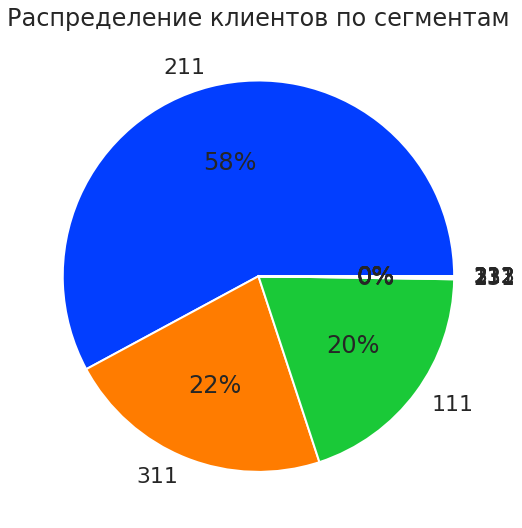

In [72]:
plt.figure(figsize = (16,9))
plt.pie(distribution.customers,labels = distribution.cluster, autopct='%.0f%%')
plt.title('Распределение клиентов по сегментам')

plt.show()

### Вывод:

Большинство клиентов принадлежит к сегментам:

211 -(recency=2, frequency=1, monetary=1) клиенты совершившие одну покупку, давностью в период от трех месяцев до года и на сумму, не превышающую 4480

111 - (recency=1, frequency=1, monetary=1) клиенты совершившие одну покупку, давностью в период больше года назад и на сумму, не превышающую 4480